In [25]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [41]:
df = pd.read_csv('Advertising.csv')
TV_ads = df['TV'].values
Total_sales = df['Sales'].values

x_scaler = StandardScaler()
y_scaler = StandardScaler()
X = x_scaler.fit_transform(TV_ads.reshape(-1, 1)).flatten()
Y = y_scaler.fit_transform(Total_sales.reshape(-1, 1)).flatten()

1. Introduction: Exploring Classical vs Quantum Regression

We will solve a regression problem using two different methods:

	•	Classical Linear Regression: A well-established and highly efficient technique for modeling linear relationships.
	•	Quantum Variational Regressor: A hybrid quantum-classical model that can capture more complex, non-linear relationships.

We’ll compare the performance of these models on a synthetic dataset and explore if quantum computing can potentially offer an advantage.

In [42]:
# define quantum device
dev = qml.device('default.qubit', wires=2)


2. Variational Quantum Circuit

A variational quantum circuit (VQC) is a hybrid quantum-classical algorithm used in quantum machine learning tasks such as regression and classification. It works by combining classical optimization methods (e.g., gradient descent) with a parameterized quantum circuit that can learn patterns in data.

In this case, the VQC is being used to fit a regression model that predicts values of Total_sales based on TV_ads. The circuit is parametrized by a set of weights (which are optimized) to adjust the transformations applied to the input data (encoded by x), allowing the circuit to fit the data.


In [43]:
@qml.qnode(dev)
def variational_circuit(x, weights):
    # Encoding the input
    qml.RX(x, wires=0)
    qml.RY(x, wires=1)
    
    # Variational layer 1
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[2], wires=0)
    qml.RX(weights[3], wires=1)
    
    # Variational layer 2
    qml.RY(weights[4], wires=0)
    qml.RX(weights[5], wires=1)
    qml.CNOT(wires=[1, 0])
    qml.RZ(weights[6], wires=1)
    qml.RY(weights[7], wires=0)
    
    return qml.expval(qml.PauliZ(0))


How does it work?

 Let's say, for example:

qml.RX(x, wires=0)
qml.RY(x, wires=1)

	•	The input data (in this case, TV_ads, after being normalized) is represented by x.
	•	To introduce this input into the quantum system, we apply rotation gates (the RX and RY gates) to encode the input data into the state of the qubits.
	•	RX(x, wires=0) and RY(x, wires=1) rotate the quantum states of the two qubits based on the value of x, putting them in a state that reflects the input.


Now, let's expand on the circuit, how would we create more complex circuits?

qml.RX(weights[0], wires=0)
qml.RY(weights[1], wires=1)
qml.CNOT(wires=[0, 1])
qml.RZ(weights[2], wires=0)
qml.RX(weights[3], wires=1)

	•	In this section, we apply a set of parametrized quantum gates. The parameters (or weights) control the amount of rotation applied to the qubits. These weights will be optimized during the training process to minimize the error of the regression model.
	•	The CNOT gate introduces entanglement between the qubits, allowing the quantum states of the qubits to become correlated in a way that classical bits can’t. This can help the circuit capture more complex relationships in the data.

We created also a second layer. This is a second physical layer in the circuit:

qml.RY(weights[4], wires=0)
qml.RX(weights[5], wires=1)
qml.CNOT(wires=[1, 0])
qml.RZ(weights[6], wires=1)
qml.RY(weights[7], wires=0)

	•	The second variational layer is similar to the first, with additional parametrized rotations and entanglement between qubits. This layer adds more complexity and expressiveness to the quantum circuit, allowing it to model more complex relationships in the data.

Note we also have one final line of code, what does it mean?

return qml.expval(qml.PauliZ(0))

	•	At the end of the quantum computation, we measure the qubits. Specifically, we measure the expectation value (denoted as expval) of the qubits’ states with respect to the PauliZ operator. This value is a number between -1 and 1 that reflects the “state” of the quantum system after applying all the gates.
	•	This measured value is interpreted as the model’s prediction for the target variable (Total_sales).

In [44]:
'''variational_circuit(x, weights), which is the actual quantum circuit (discussed earlier). 
The circuit performs calculations based on the input x and the weights and returns a prediction.'''

def variational_regressor(x, weights):
    return variational_circuit(x, weights)

Here, instead of a classical transformation, we pass x and a set of weights (which represent the parameters of the quantum circuit) to a quantum circuit called variational_circuit(). The circuit processes the input and produces a predicted value. Think of this as replacing the function f(x) = Wx + b (for linear regression) with a quantum circuit that applies a series of quantum transformations to x, determined by the weights.

In [45]:
'''Let's use MSE to minimize the cost function: '''
def cost(weights, X, Y):
    predictions = np.array([variational_regressor(x, weights) for x in X])
    return np.mean((predictions - Y) ** 2)

'''Initialize the weights of the Quantum Circuit randomly'''
np.random.seed(42)
weights = np.random.randn(8)
''' Using Gradient Descent we chose to minimize the cost function by adjusting the weights of the circuit. '''
opt = qml.GradientDescentOptimizer(stepsize=0.01)

batch_size = 20  # Define the batch size
epochs = 150
weight_list = []
num_batches = len(X) // batch_size
epoch_set = {0} | {i for i in range(4, 50, 5)} | {99, 149}
for epoch in range(epochs):
    for i in range(num_batches):
        X_batch = X[i*batch_size:(i+1)*batch_size]
        Y_batch = Y[i*batch_size:(i+1)*batch_size]
        weights = opt.step(lambda w: cost(w, X_batch, Y_batch), weights)
    if epoch in epoch_set:
        train_cost = cost(weights, X, Y)
        weight_list.append(weights)
        print(f"Epoch {epoch + 1}: Train cost = {train_cost}")

Epoch 1: Train cost = 1.0846616429958722
Epoch 5: Train cost = 0.8720152074727412
Epoch 10: Train cost = 0.6983007747470912
Epoch 15: Train cost = 0.6012583849603214
Epoch 20: Train cost = 0.5452060271320041
Epoch 25: Train cost = 0.5106866334195334
Epoch 30: Train cost = 0.4883917253977589
Epoch 35: Train cost = 0.47339747149832645
Epoch 40: Train cost = 0.46290291040757675
Epoch 45: Train cost = 0.45525924449672206
Epoch 50: Train cost = 0.44947443420304384
Epoch 100: Train cost = 0.42582769549898253
Epoch 150: Train cost = 0.41878894645660525


How Does This Relate to Classical Regression?

If you are familiar with classical regression techniques like linear regression or polynomial regression, you can think of this quantum model in a similar way, but with a different mechanism for learning the mapping from input to output:

	•	In classical regression, we model the relationship between X and Y with a linear function like Y = WX + b. The coefficients W and b are adjusted to minimize the prediction error.
	•	In this quantum model, we are still trying to learn a function from X to Y, but instead of using a simple linear function, we use a quantum circuit that transforms the input data based on parameterized quantum gates. The parameters (weights) of these gates are optimized using the same principles (gradient descent) that you would use in classical machine learning models.

The advantage of using a quantum model here is that it can capture more complex, non-linear relationships in the data, potentially outperforming classical regression models in certain cases.

Test cost: 1.0846616429958722


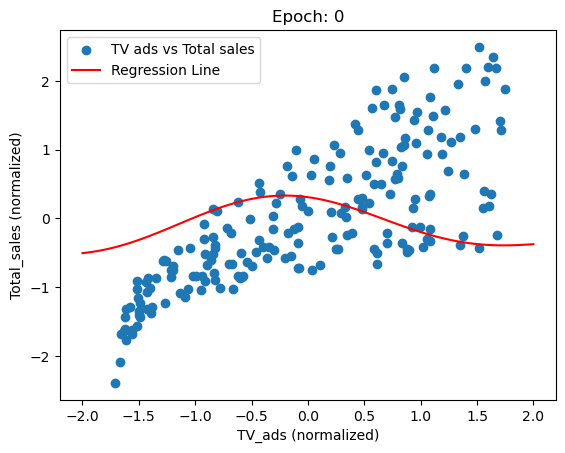

Test cost: 0.8720152074727412


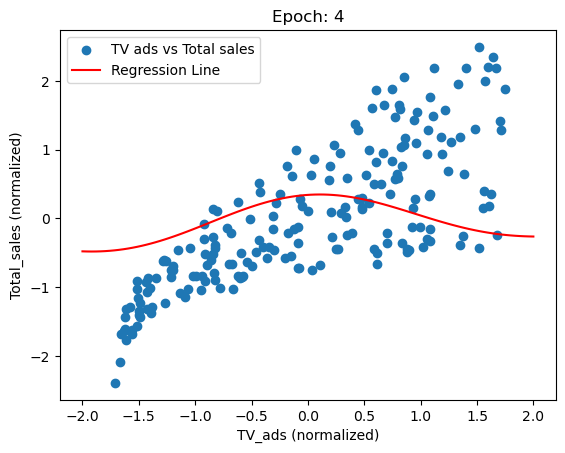

Test cost: 0.6983007747470912


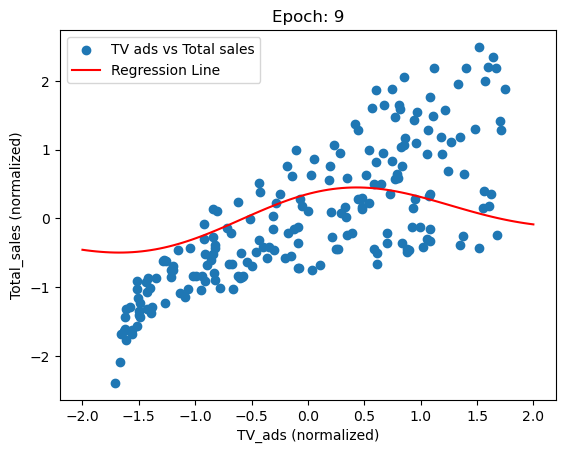

Test cost: 0.6012583849603214


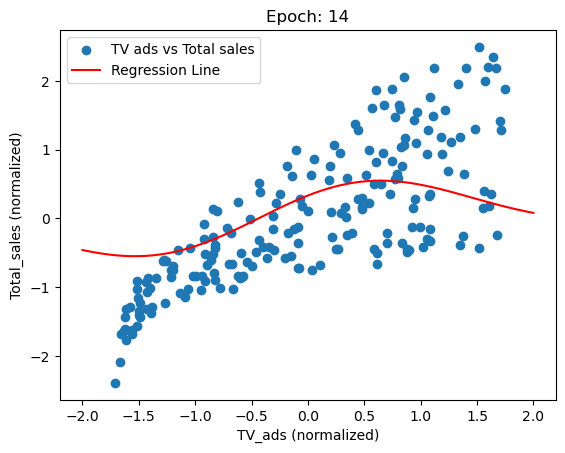

Test cost: 0.5452060271320041


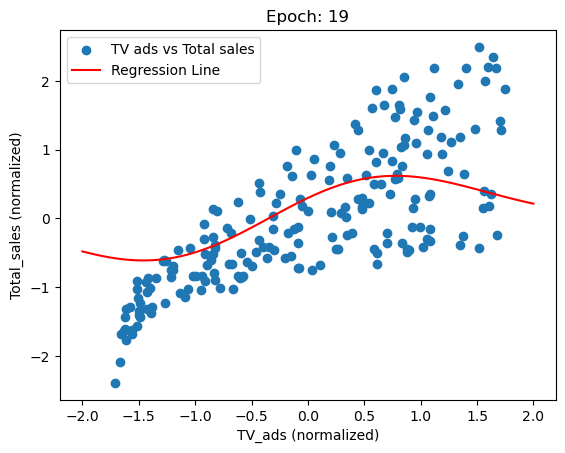

Test cost: 0.5106866334195334


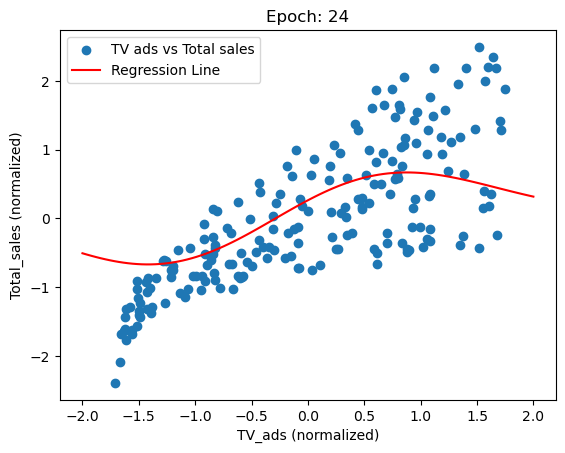

Test cost: 0.4883917253977589


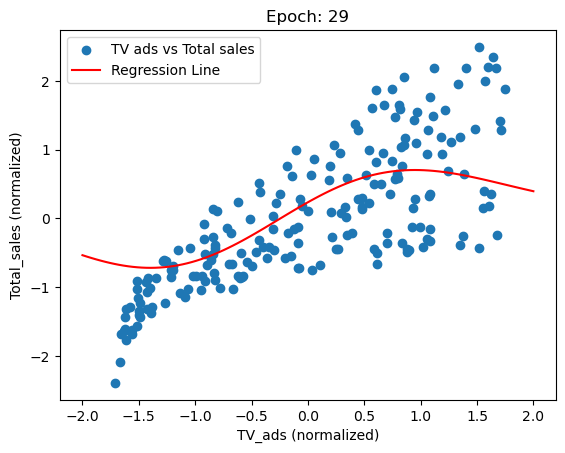

Test cost: 0.47339747149832645


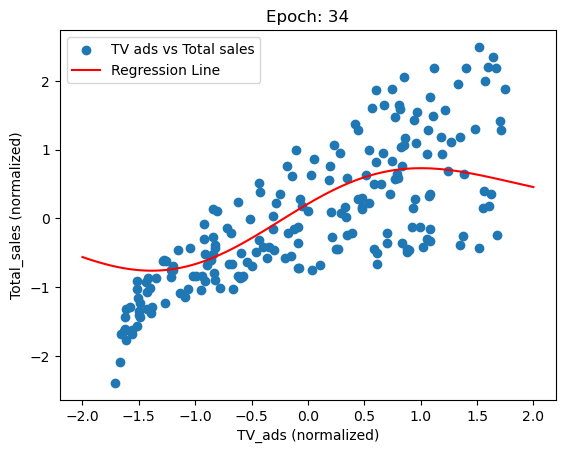

Test cost: 0.46290291040757675


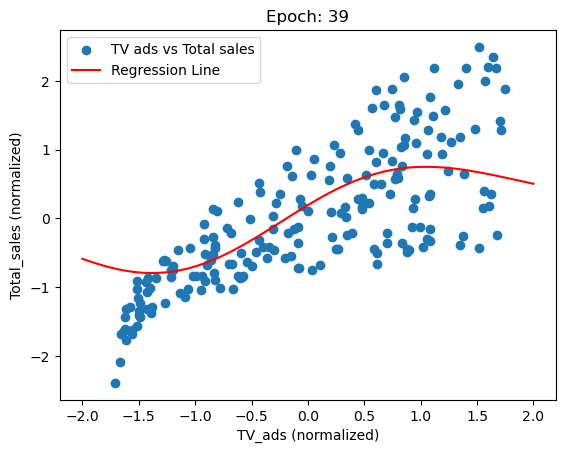

Test cost: 0.45525924449672206


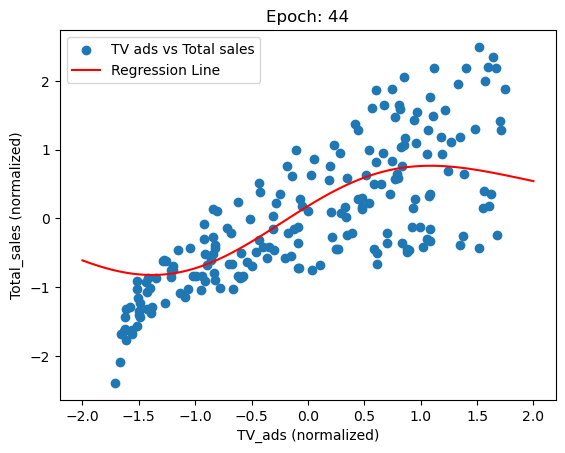

Test cost: 0.44947443420304384


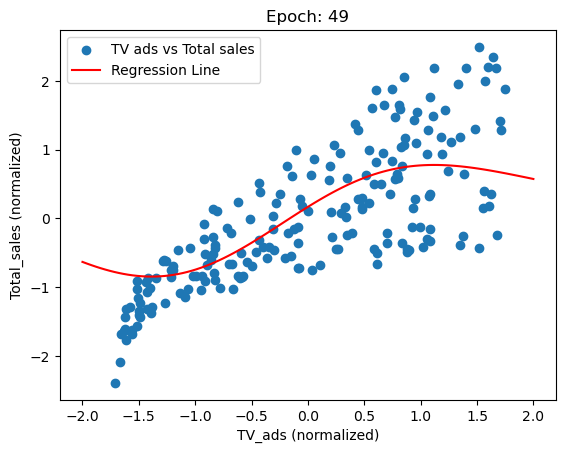

Test cost: 0.42582769549898253


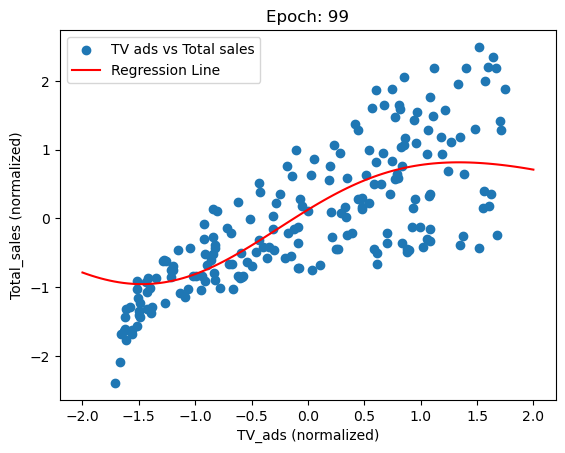

Test cost: 0.41878894645660525


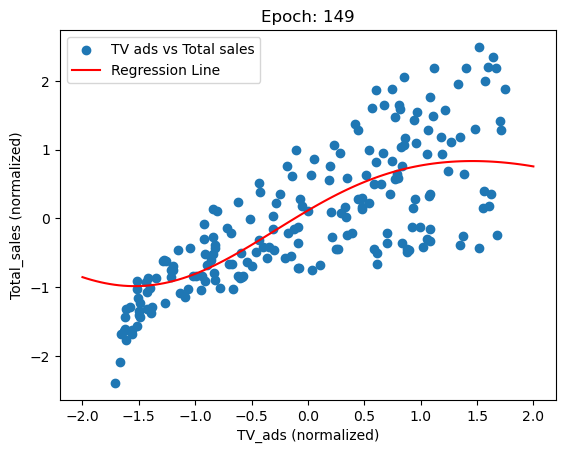

In [46]:
# Predictions on test data
epoch_list = [0] + [i for i in range(4, 50, 5)] + [99, 149]
for i, weights in enumerate(weight_list):
    test_predictions = np.array([variational_regressor(x, weights) for x in X])
    test_cost = cost(weights, X, Y)
    print(f"Test cost: {test_cost}")

    # Plot the results
    plt.scatter(X, Y, label='TV ads vs Total sales')
    plt.plot(np.linspace(-2, 2, 100), [variational_regressor(x, weights) for x in np.linspace(-2, 2, 100)], label='Regression Line', color='red')
    plt.xlabel('TV_ads (normalized)')
    plt.ylabel('Total_sales (normalized)')
    plt.title(f'Epoch: {epoch_list[i]}')
    plt.legend()
    plt.show()

From the graph we can say:

The result you’ve obtained from the variational quantum regressor shows a non-linear regression line (in red) that fits the underlying pattern of the data, which is the relationship between TV_ads and Total_sales. Unlike a typical linear regression, where the regression line would be straight, this quantum model has captured the curve in the data. The red regression line follows the trend more closely, especially where there is curvature in the data, something that a simple linear regression model might miss or poorly approximate.

This outcome demonstrates one of the key strengths of quantum circuits in regression: their ability to model non-linear relationships more effectively due to the flexibility in how data can be transformed and represented within a quantum system. In a classical regression model (like linear regression), the model assumes a linear relationship between the input and output, and while you could increase the complexity using polynomial regression or other non-linear transformations, a quantum model can express these relationships inherently with fewer parameters by leveraging quantum gates and entanglement.


-----------------

Advantages:

	•	Expressive Power: Quantum circuits can naturally model complex, non-linear relationships. In classical machine learning, you would need more complex models (such as polynomial regression or neural networks) to capture this type of pattern, whereas a quantum circuit can handle these transformations in a lower-dimensional space.
	•	Fewer Parameters: Quantum models may require fewer parameters than some classical non-linear models, which could reduce the risk of overfitting in cases with smaller datasets.

Disadvantages:

	•	Training Complexity: Training a quantum model is computationally more intensive compared to classical models. Optimizing the parameters of a quantum circuit requires running a hybrid quantum-classical optimization loop, which can be slower and harder to tune than classical algorithms.
	•	Current Limitations: Quantum computers are still in an early stage of development. Simulating quantum circuits on classical computers (as we often do) is resource-intensive, and real quantum hardware has limitations in terms of qubit number and noise.

---------------

	How Does This Help with Regression?
    
    •	Learning Complex Patterns: The circuit acts as a flexible model where the gates (and the corresponding weights) can be adjusted to fit complex patterns in the data. The more layers or parameters we add, the more expressive the circuit becomes.
	•	Optimization: The weights in the circuit are optimized using a classical algorithm (like gradient descent) to minimize the difference between the circuit’s predictions and the true values of Total_sales. This hybrid quantum-classical approach leverages the strengths of both quantum and classical computing.

-------------

Why Use a Quantum Circuit for Regression?

	•	Expressive Power: Quantum circuits can represent complex functions in fewer dimensions, capturing relationships in data that may be difficult for classical models to express.
	•	Quantum Entanglement and Superposition: By entangling qubits, the quantum model can represent complex correlations in the data, potentially giving it an edge over classical models in certain cases (especially with non-linear data).

-----------

Simplified Analogy:

	•	Imagine you have a simple mathematical model where you rotate numbers in different ways and then combine them. Each rotation is controlled by a parameter that can be adjusted to fit the data better.
	•	In this analogy, the quantum circuit’s rotation gates (RX, RY, RZ) are the tools you use to adjust the “fit.” But unlike classical models, these rotations happen in a quantum world where data can be in multiple states at once (superposition) and where qubits can influence each other directly (entanglement).


--------------

In summary, while the quantum model has provided a more nuanced fit than a simple linear regression model, it comes at the cost of increased complexity and computational overhead. As quantum hardware matures, this kind of approach might become more practical, especially for datasets with highly complex, non-linear relationships. However, for simpler datasets, classical regression methods might still be the more efficient choice.

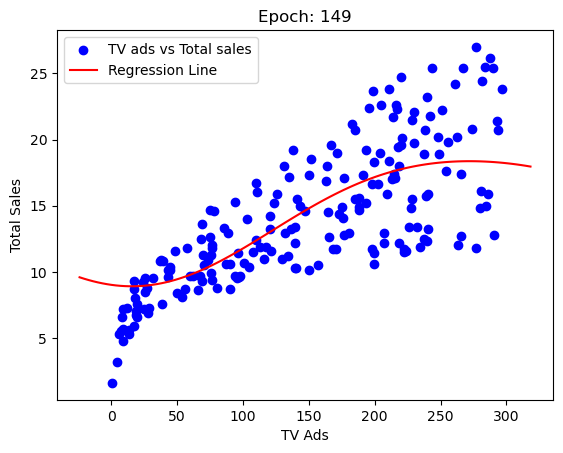

In [49]:
original_X = x_scaler.inverse_transform(np.linspace(-2, 2, 100).reshape(-1, 1)).flatten()

predicted_Y = [variational_regressor(x, weight_list[len(weight_list) - 1]) for x in np.linspace(-2, 2, 100)]
unnormalized_Y = y_scaler.inverse_transform(np.array(predicted_Y).reshape(-1, 1)).flatten()
plt.scatter(x_scaler.inverse_transform(X.reshape(-1, 1)).flatten(), y_scaler.inverse_transform(Y.reshape(-1, 1)).flatten(), label='TV ads vs Total sales', color='blue')
plt.plot(original_X, unnormalized_Y, label='Regression Line', color='red')

plt.title(f'Epoch: {epoch}')
plt.xlabel('TV Ads')
plt.ylabel('Total Sales')
plt.legend()
plt.show()